## Preparation

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Dataset
from PIL import Image
from timm.models import create_model
from timm.data import create_transform

C:\Users\aldem\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Dataset

In [3]:
root_path = r"C:\Users\aldem\IdeaProjects\courseSeminar\venv\Scripts\dataset"

In [4]:
model_save_dir = "C:/Users/aldem/IdeaProjects/courseSeminar/venv/Scripts/model_cnn"

In [5]:
transform = transforms.Compose([
    transforms.Resize((110, 110)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [9]:
class CustomImageFolder(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.classes, self.class_to_idx = self._find_classes(self.root)
        self.samples = self._make_dataset(self.root, self.class_to_idx)

    def _find_classes(self, dir):
        classes = [d.name for d in os.scandir(dir) if d.is_dir() and not d.name.startswith('.')]
        classes.sort()
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx

    def _make_dataset(self, dir, class_to_idx):
        instances = []
        dir = os.path.expanduser(dir)
        for target in sorted(class_to_idx.keys()):
            d = os.path.join(dir, target)
            if not os.path.isdir(d):
                continue
            for root, _, fnames in sorted(os.walk(d)):
                for fname in sorted(fnames):
                    if self._is_valid_file(fname):
                        path = os.path.join(root, fname)
                        item = (path, class_to_idx[target])
                        instances.append(item)
        return instances

    def _is_valid_file(self, filename):
        valid_extensions = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')
        return filename.lower().endswith(valid_extensions)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, target = self.samples[idx]
        try:
            sample = Image.open(path).convert('RGB')
            if self.transform:
                sample = self.transform(sample)
            return sample, target  # Возвращаем только изображение и метку
        except OSError:
            print(f"Ошибка при загрузке изображения: {path}. Пропускаем это изображение.")
            return self.__getitem__(0) if idx == 0 else self.__getitem__(idx - 1)


In [10]:
full_dataset = CustomImageFolder(root=root_path, transform=transform)

In [11]:
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

In [12]:
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

In [13]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [14]:
class_names = full_dataset.classes

In [15]:
print("Class:", class_names)

Class: ['angry', 'happy', 'sad', 'surprise']


## Build Architecture

In [16]:
class ConvolutionalNet(nn.Module):
    def __init__(self, num_classes=4):
        super(ConvolutionalNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1, stride=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1, stride=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1, stride=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.maxpool = nn.MaxPool2d(kernel_size=(2, 2))
        self.adaptivepool = nn.AdaptiveAvgPool2d((1, 1))  # Используем адаптивный пулинг

        self.fc1 = nn.Linear(in_features=128, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=num_classes)
        self.bn_fc1 = nn.BatchNorm1d(512)
        self.bn_fc2 = nn.BatchNorm1d(128)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.maxpool(out)
        out = F.relu(self.bn3(self.conv3(out)))
        out = F.relu(self.bn4(self.conv4(out)))
        out = self.maxpool(out)
        out = F.relu(self.bn5(self.conv5(out)))
        out = F.relu(self.bn6(self.conv6(out)))
        out = self.maxpool(out)
        out = self.adaptivepool(out)  # Применяем адаптивный пулинг
        out = out.view(out.size(0), -1)
        out = F.relu(self.bn_fc1(self.fc1(out)))
        out = F.relu(self.bn_fc2(self.fc2(out)))
        out = self.fc3(out)
        return out

    def get_total_params(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


In [22]:
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100.0 * correct / total
    return epoch_loss, epoch_accuracy

In [23]:
def validate_model(model, validation_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(validation_loader)
    epoch_accuracy = 100.0 * correct / total
    return epoch_loss, epoch_accuracy

In [24]:
def train_and_evaluate(model, train_loader, validation_loader, criterion, optimizer, device, num_epochs=10, model_save_dir="models"):
    best_accuracy = 0.0
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    os.makedirs(model_save_dir, exist_ok=True)

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train_model(model, train_loader, criterion, optimizer, device)
        val_loss, val_accuracy = validate_model(model, validation_loader, criterion, device)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"  Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
        print(f"  Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

        model_path = os.path.join(model_save_dir, f"model_epoch_{epoch+1}.pt")
        torch.save(model.state_dict(), model_path)
        print(f"Model saved at {model_path}")

        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model_path = model_path
            print(f"Best model updated with accuracy: {best_accuracy:.2f}%")

    return {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies,
        "best_model_path": best_model_path
    }

## Testing

In [25]:
model = ConvolutionalNet(num_classes=len(class_names)).to(device)

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [28]:
results = train_and_evaluate(
    model,
    train_loader,
    test_loader,
    criterion,
    optimizer,
    device,
    num_epochs=40,
    model_save_dir=model_save_dir
)

Epoch 1/40
  Train Loss: 0.1955, Train Accuracy: 92.77%
  Validation Loss: 0.9719, Validation Accuracy: 70.30%
Model saved at C:/Users/aldem/IdeaProjects/courseSeminar/venv/Scripts/model_cnn\model_epoch_1.pt
Best model updated with accuracy: 70.30%
Epoch 2/40
  Train Loss: 0.1790, Train Accuracy: 93.74%
  Validation Loss: 1.8478, Validation Accuracy: 65.51%
Model saved at C:/Users/aldem/IdeaProjects/courseSeminar/venv/Scripts/model_cnn\model_epoch_2.pt
Epoch 3/40
  Train Loss: 0.1507, Train Accuracy: 94.71%
  Validation Loss: 1.0991, Validation Accuracy: 71.35%
Model saved at C:/Users/aldem/IdeaProjects/courseSeminar/venv/Scripts/model_cnn\model_epoch_3.pt
Best model updated with accuracy: 71.35%
Epoch 4/40
  Train Loss: 0.1592, Train Accuracy: 94.35%
  Validation Loss: 1.7803, Validation Accuracy: 61.43%
Model saved at C:/Users/aldem/IdeaProjects/courseSeminar/venv/Scripts/model_cnn\model_epoch_4.pt
Epoch 5/40
  Train Loss: 0.1658, Train Accuracy: 93.99%
  Validation Loss: 1.4438, Val

## Monitoring the results

In [29]:
def monitoring_results(results, metrics, labels, title, y_label):
    results_metrics = [results[metric] for metric in metrics]

    for result, label in zip(results_metrics, labels):
        plt.plot(result, label=label)

    plt.legend(frameon=False)
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel(y_label)
    plt.tight_layout()
    plt.show()

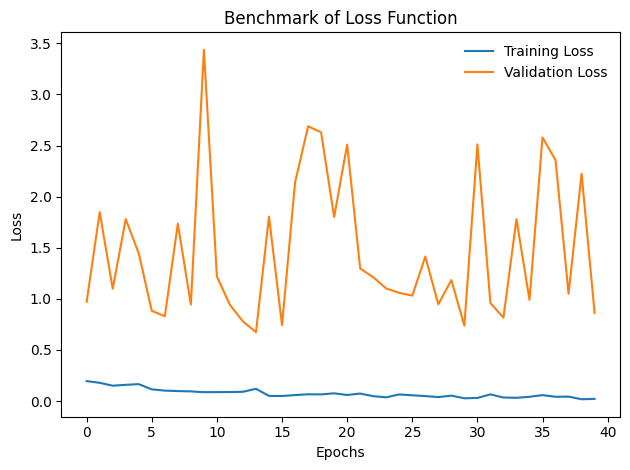

In [30]:
monitoring_results(results,
                   metrics=["train_losses", "val_losses"],
                   labels=["Training Loss", "Validation Loss"],
                   title="Benchmark of Loss Function",
                   y_label="Loss")

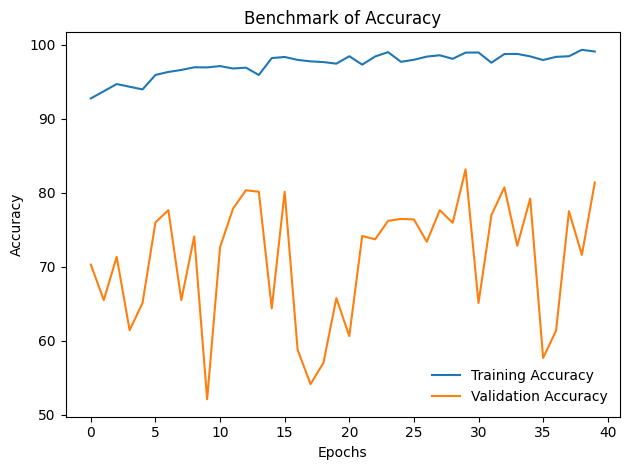

In [31]:
monitoring_results(results,
                   metrics=["train_accuracies", "val_accuracies"],
                   labels=["Training Accuracy", "Validation Accuracy"],
                   title="Benchmark of Accuracy",
                   y_label="Accuracy")


In [32]:
best_model_path = results["best_model_path"]

In [33]:
def testing(model_path, test_loader, device):
    model = get_best_model(model_path)
    model.eval()

    test_results = []
    lst_ytest = []
    lst_ypred = []

    with torch.no_grad():
        for images, labels in test_loader:  
            images, labels = images.to(device), labels.to(device)

            logits = model(images)
            y_probs = F.softmax(logits, dim=1).cpu().numpy() 
            y_pred = np.argmax(y_probs, axis=1)

            lst_ytest.extend(labels.cpu().numpy())
            lst_ypred.extend(y_pred)

    accuracy = accuracy_score(lst_ytest, lst_ypred)
    precision = precision_score(lst_ytest, lst_ypred, average='weighted')
    recall = recall_score(lst_ytest, lst_ypred, average='weighted')
    f1 = f1_score(lst_ytest, lst_ypred, average='weighted')

    test_results.append({
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    })

    frame_results = pd.DataFrame(test_results)

    return frame_results


In [37]:
def get_best_model(model_path):
    best_model = ConvolutionalNet()
    best_model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
    best_model = best_model.to(device)
    return best_model

In [38]:
testing_results = testing(best_model_path, test_loader, device)

C:\Users\aldem\AppData\Local\Temp\ipykernel_16900\2491832358.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(model_path, map_locati

In [39]:
print(testing_results)

   accuracy  precision  recall  f1_score
0    0.8318   0.841704  0.8318  0.831934


## Interface

In [40]:
os.chdir(root_path)

In [41]:
print("Image-dim: ")
print(next(iter(test_loader))[0][12].shape)
print("Tensor of images: ")
print(next(iter(test_loader))[0][12])

Image-dim: 
torch.Size([3, 110, 110])
Tensor of images: 
tensor([[[-2.1179, -2.1008, -2.1008,  ..., -0.3712, -0.3541, -0.3541],
         [-2.1008, -2.1008, -2.1008,  ..., -0.3883, -0.3369, -0.3369],
         [-2.1008, -2.1008, -2.1008,  ..., -0.3541, -0.3541, -0.3369],
         ...,
         [ 1.1358,  1.1187,  1.1358,  ..., -0.0116,  0.0056, -0.0287],
         [ 1.1187,  1.1015,  1.1358,  ..., -0.0287, -0.0116, -0.0287],
         [ 1.1015,  1.1015,  1.1015,  ..., -0.0116, -0.0116, -0.0287]],

        [[-2.0182, -2.0182, -2.0182,  ..., -0.3200, -0.3025, -0.2675],
         [-2.0182, -2.0182, -2.0182,  ..., -0.3200, -0.2675, -0.2675],
         [-2.0182, -2.0182, -2.0182,  ..., -0.2850, -0.2850, -0.2675],
         ...,
         [ 0.1877,  0.1702,  0.2052,  ...,  0.1352,  0.1527,  0.1176],
         [ 0.1702,  0.1527,  0.1877,  ...,  0.1176,  0.1352,  0.1176],
         [ 0.1527,  0.1527,  0.1527,  ...,  0.1352,  0.1527,  0.1352]],

        [[-1.7522, -1.7870, -1.7870,  ..., -0.3230, -0.2881

In [42]:
def inference(model_path, data_loader, device, sample_pos):
    model = get_best_model(model_path)
    model.to(device)
    model.eval()

    batch = next(iter(data_loader))
    x_test = batch[0][sample_pos].unsqueeze(0).to(device)
    y_test = batch[1][sample_pos].to(device)

    with torch.no_grad():
        output = model(x_test)
        probs = F.softmax(output, dim=1)

    return x_test, y_test, probs

In [43]:
image, label, prob_dist = inference(model_path=best_model_path,
                                    data_loader=test_loader,
                                    device=device,
                                    sample_pos=12)
print(f"True label: {label}")
print(f"Prob distribution: {prob_dist}")

C:\Users\aldem\AppData\Local\Temp\ipykernel_16900\2491832358.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(model_path, map_locati

True label: 2
Prob distribution: tensor([[3.9652e-03, 4.3229e-06, 7.3286e-01, 2.6317e-01]])
